In [69]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import statsmodels.formula.api as smf

import scipy.stats as stats

sns.set_theme(style="whitegrid")

# Ice Fishing Fleet Visualizations


In [70]:
landings = pd.read_csv("../data/derived/landings_cleaned.csv", low_memory=False)

In [71]:
# ax = landings.groupby(by=['seasonal_year']).vessel_type.value_counts(normalize=True).unstack().plot.bar(stacked=True, color={'ice': '#b0dac2', 'water': '#436b88'})
# ax.set_ylabel('Share of landings (%)')
# ax.set_xlabel('Seasonal Year (August-August)')
# ax.legend = plt.legend()
# ax.legend.set_title('Type of Fishing')

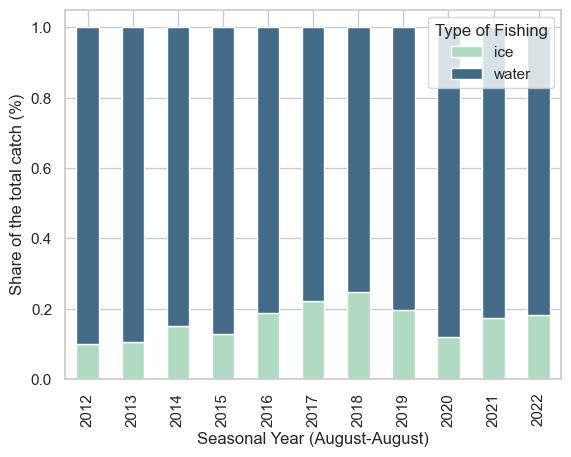

In [72]:
ax = (
    landings.groupby(by=["seasonal_year", "vessel_type"])
    .amount_in_kg.sum()
    .unstack()
    .apply(lambda x: x / sum(x), axis="columns")
    .plot(kind="bar", stacked=True, color={"ice": "#b0dac2", "water": "#436b88"})
)
ax.set_ylabel("Share of the total catch (%)")
ax.set_xlabel("Seasonal Year (August-August)")
ax.legend = plt.legend()
ax.legend.set_title("Type of Fishing")

# change axes to 0-100
# show entire fishing industry as the reference.. maybe second viz look just at nearshore and just halibut

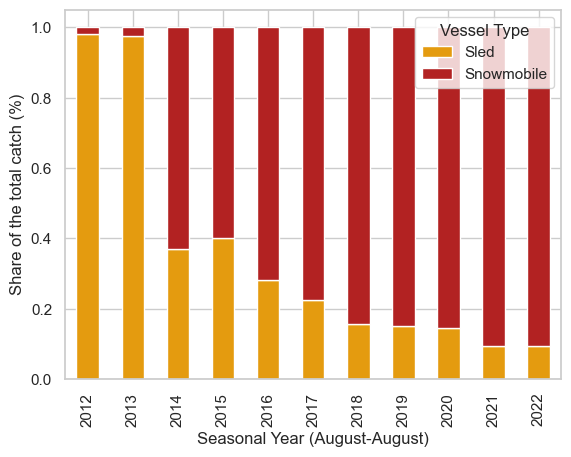

In [73]:
ax = (
    landings.query('vessel in ["Sled", "Snowmobile"]')
    .groupby(by=["seasonal_year", "vessel"])
    .amount_in_kg.sum()
    .unstack()
    .apply(lambda x: x / sum(x), axis="columns")
    .plot(kind="bar", stacked=True, color={"Sled": "#e49b0f", "Snowmobile": "#b22222"})
)
ax.set_ylabel("Share of the total catch (%)")
ax.set_xlabel("Seasonal Year (August-August)")
ax.legend = plt.legend()
ax.legend.set_title("Vessel Type")

In [74]:
landings["year_month"] = landings.sales_date.apply(lambda x: "-".join(x.split("-")[:2]))

In [75]:
# # Reorder the 'vessel' groups
# landings['vessel'] = pd.Categorical(landings['vessel'],
#                                    categories=['Larger Inshore Vessel', 'Dinghy', 'Sled', 'Snowmobile'],
#                                    ordered=True)

# # Create a stacked bar plot with custom colors and reordered categories
# ax = landings.groupby(by=['seasonal_year', 'vessel']).size().unstack().plot.bar(
#     stacked=True, figsize=(10, 10),
#     color={'Sled': '#e49b0f', 'Snowmobile': '#b22222', 'Dinghy': '#436b88', 'Larger Inshore Vessel': '#104e8b'})

# ax.set_ylabel("Number of landings")
# ax.set_xlabel("Month - Year")
# ax.legend(title="Vessel Type")
# plt.legend(bbox_to_anchor=(1, .05), loc='lower right')

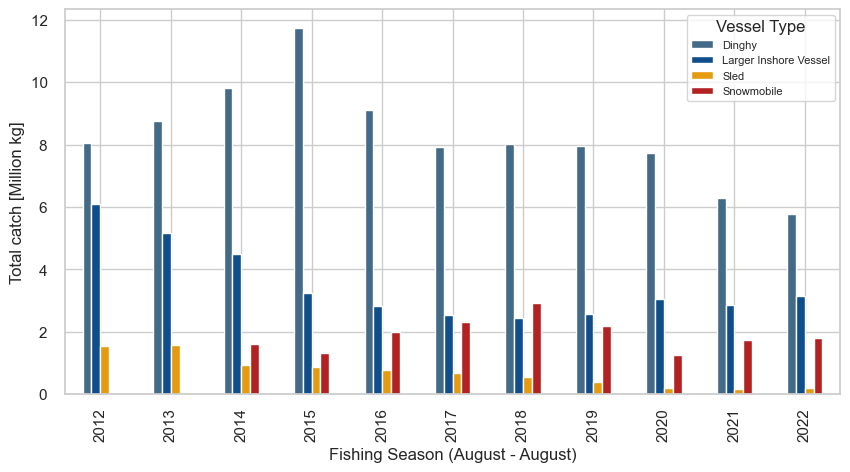

In [76]:
ax = (
    landings.query(
        'vessel in ["Sled", "Snowmobile", "Dinghy", "Larger Inshore Vessel"]'
    )
    .groupby(by=["seasonal_year", "vessel"])
    .amount_in_kg.sum()
    .unstack()
    .plot(
        kind="bar",
        stacked=False,
        figsize=(10, 5),
        color={
            "Sled": "#e49b0f",
            "Snowmobile": "#b22222",
            "Dinghy": "#436b88",
            "Larger Inshore Vessel": "#104e8b",
        },
    )
)
ax.set_ylabel("Total catch [Million kg]")
ax.set_xlabel("Fishing Season (August - August)")
ax.legend(title="Vessel Type", fontsize="8")


def millions_formatter(x, pos):
    return f"{x / 1e6:.0f} "


ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# stacked bar chart hard to read when they do not add up to total
# grouped bar chart
# test change

### Economic

In [77]:
# fishers = landings.groupby(['seasonal_year', 'vessel_type']).seller_id.nunique().unstack()
# ax = fishers.plot(kind='bar', stacked=True, color={'ice': '#b0dac2', 'water': '#436b88'})
# ax.set_ylabel('Count of Fishers')
# ax.set_xlabel('Fishing Season (August-August)')
# ax.legend(title="Fishing Type")


# fishers = pd.melt(frame=fishers, ignore_index=False, value_vars=['ice', 'water'], value_name='num_fishers')

In [78]:
# revenue = landings.groupby(['seasonal_year', 'vessel_type']).value.sum().unstack()
# ax = revenue.plot(kind='bar', stacked=True, color={'ice': '#b0dac2', 'water': '#436b88'})
# ax.set_ylabel('Gross Revenue [Million DKK]')
# ax.set_xlabel('Fishing Season (August-August)')
# ax.legend(title="Fishing Type")

# def millions_formatter(x, pos):
#      return f'{x / 1e6:.0f} '

# ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

In [79]:
fisher_types = pd.read_csv("../data/derived/fishertypes.csv")

In [80]:
landings = landings.merge(
    fisher_types.drop(columns="ice_proportion_of_income"),
    on=["seller_id", "seasonal_year"],
)

In [81]:
income = (
    landings.groupby(["seasonal_year", "seller_id"])
    .value.sum()
    .rename("income")
    .reset_index()
)
income = income.merge(
    fisher_types.drop(columns="ice_proportion_of_income"),
    on=["seller_id", "seasonal_year"],
)
median_income = income.groupby(["seasonal_year", "type"]).income.median()
median_income = median_income.rename("median_income").reset_index()

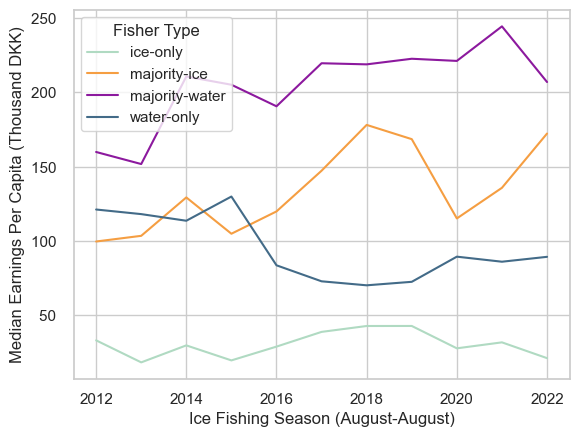

In [82]:
# Set custom colors for 'ice' and 'water'
custom_palette = {
    "ice-only": "#b0dac2",
    "majority-ice": "#f59e42",
    "majority-water": "#8c199e",
    "water-only": "#436b88",
}

ax = sns.lineplot(
    data=median_income,
    x="seasonal_year",
    y="median_income",
    hue="type",
    palette=custom_palette,
)
ax.set_xlabel("Ice Fishing Season (August-August)")
ax.set_ylabel("Median Earnings Per Capita (Thousand DKK)")
ax.legend(title="Fisher Type")


def thousands_formatter(x, pos):
    return f"{x / 1e3:.0f} "


ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

In [83]:
income_by_locality = (
    landings.groupby(["seasonal_year", "seller_id", "sellers_locality"])
    .value.sum()
    .rename("income")
    .reset_index()
)
income_by_locality = income_by_locality.merge(
    fisher_types.drop(columns="ice_proportion_of_income"),
    on=["seller_id", "seasonal_year"],
)
median_income_by_locality = income_by_locality.groupby(
    [
        "seasonal_year",
        "sellers_locality",
        "type",
    ]
).income.median()
median_income_by_locality = median_income_by_locality.rename(
    "median_income"
).reset_index()
median_income_by_locality

,seasonal_year,sellers_locality,type,median_income
0,2012,Aasiaat,water-only,39404.750
1,2012,Akunnaaq,water-only,82891.000
2,2012,Arsuk,water-only,194720.500
3,2012,Attu,water-only,196703.515
4,2012,Iginniarfik,water-only,60045.365
...,...,...,...,...
1115,2022,Upernavik Kujalleq,majority-water,149926.500
1116,2022,Upernavik Kujalleq,water-only,61105.000
1117,2022,Uummannaq,majority-ice,159086.000
1118,2022,Uummannaq,majority-water,200800.500


In [84]:
family_income = pd.read_csv("../data/raw/family-income.csv")

family_income = family_income[["locality", "time", "family type", "Family income"]]
family_income = family_income.rename(
    columns={
        "locality": "sellers_locality",
        "time": "seasonal_year",
        "family type": "family_type",
        "Family income": "family_income",
    }
)
family_income = family_income.pivot(
    index=["seasonal_year", "sellers_locality"],
    columns="family_type",
    values="family_income",
)


median_income_by_locality = median_income_by_locality.pivot(
    index=["seasonal_year", "sellers_locality"], columns="type", values="median_income"
)

median_income_by_locality = median_income_by_locality.merge(
    family_income, left_index=True, right_index=True
).to_csv("../data/derived/median_income_by_locality.csv")

In [85]:
# # Set custom colors for 'ice' and 'water'
# custom_palette = {'ice': '#b0dac2', 'water': '#436b88'}

# median_earnings_per_capita = pd.melt(frame=landings.groupby(['seasonal_year', 'vessel_type', 'seller_id']).amount_in_kg.sum().unstack(1).groupby('seasonal_year').median(), ignore_index=False, value_name='median_catch_per_capita', value_vars=['ice', 'water'])
# median_earnings_per_capita.reset_index(inplace=True)
# ax = sns.lineplot(data=median_earnings_per_capita, x='seasonal_year', y='median_catch_per_capita', hue='vessel_type', palette=custom_palette)
# ax.set_xlabel("Ice Fishing Season (August-August)")
# ax.set_ylabel("Median Catch (kg) Per Capita")
# ax.legend(title="Fishing Type")

,trend,seasonal,vessel_type
year_month,,,
2012-08-01,NaN,-46.930769,ice
2012-09-01,NaN,-64.870352,ice
2012-10-01,NaN,-75.399519,ice
2012-11-01,NaN,-11.123477,ice
2012-12-01,NaN,2.115065,ice
...,...,...,...
2023-05-01,NaN,38.844231,ice
2023-06-01,NaN,6.102565,ice
2023-07-01,NaN,3.627565,ice


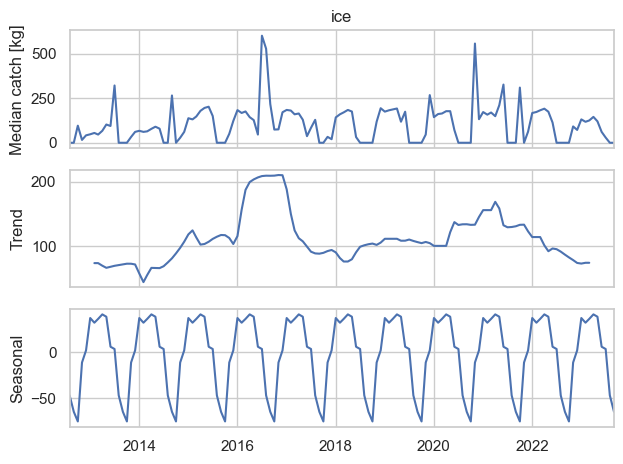

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

median_amount = (
    landings.groupby(by=["year_month", "vessel_type"])
    .amount_in_kg.median()
    .unstack()
    .reset_index()
)

median_amount.year_month = pd.to_datetime(median_amount.year_month, format="%Y-%m")
median_amount.set_index("year_month", inplace=True)

median_amount.fillna(0, inplace=True)
result = seasonal_decompose(median_amount["ice"], model="additive")
fig = result.plot(resid=False)
fig.axes[0].set_ylabel("Median catch [kg]")

median_amount_decomposed = pd.DataFrame()
median_amount_decomposed["trend"] = result.trend
median_amount_decomposed["seasonal"] = result.seasonal
median_amount_decomposed["vessel_type"] = "ice"
median_amount_decomposed

In [87]:
result.trend.value_counts()

trend
100.583333    4
111.583333    4
114.270833    3
156.041667    3
73.833333     2
             ..
203.708333    1
199.583333    1
187.458333    1
156.458333    1
88.489583     1
Name: count, Length: 109, dtype: int64

# Ice Fishing Season Visualizations


Text(0, 0.5, 'Greenland halibut price paid to fishers (DKK / kg)')

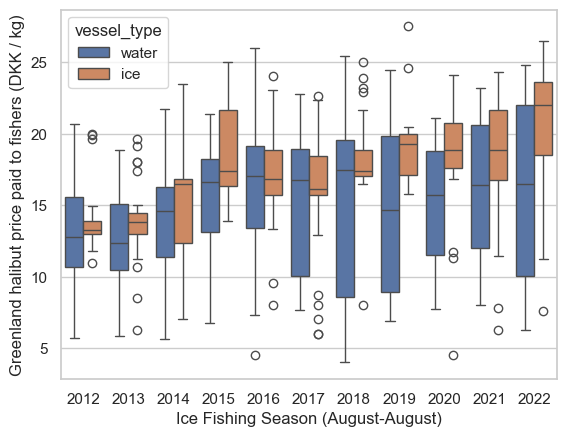

In [88]:
ppk_locality = pd.read_csv("../data/derived/ppk_locality.csv", low_memory=False)

ax = sns.boxplot(
    data=ppk_locality, x="seasonal_year", y="ppk", legend=True, hue="vessel_type"
)

ax.set_xlabel("Ice Fishing Season (August-August)")
ax.set_ylabel("Greenland halibut price paid to fishers (DKK / kg)")

In [89]:
(
    ppk_locality.set_index("sellers_locality")
    .groupby("seasonal_year")
    .ppk.idxmax()
    .rename("Locality with the maximum PPK")
)

seasonal_year
2012        Kapisillit
2013         Ilulissat
2014           Aasiaat
2015          Oqaatsut
2016           Saarloq
2017    Kitsissuarsuit
2018    Kitsissuarsuit
2019          Ilimanaq
2020       Kangaatsiaq
2021          Ikerasak
2022          Ilimanaq
Name: Locality with the maximum PPK, dtype: object

In [90]:
(
    ppk_locality.set_index("sellers_locality")
    .groupby("seasonal_year")
    .ppk.idxmin()
    .rename("Locality with the minimum PPK")
)

seasonal_year
2012                      Itilleq
2013                  Sarfannguit
2014                     Tasiilaq
2015                  Sarfannguit
2016                      Kulusuk
2017                   Kangaamiut
2018                   Narsarsuaq
2019                Alluitsup Paa
2020                      Paamiut
2021                  Kangaatsiaq
2022    Ikerasaarsuk, Kangaatsiaq
Name: Locality with the minimum PPK, dtype: object

## Total Daily Catch During Fishing Seasons 2012-2022


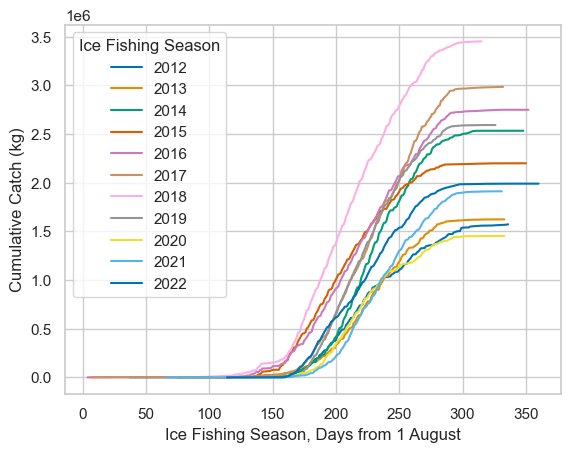

In [91]:
total_daily_catch = pd.read_csv("../data/derived/total_daily_catch.csv")
ax = sns.lineplot(
    total_daily_catch,
    x="seasonal_day",
    y="cumulative",
    hue="seasonal_year",
    palette="colorblind",
)

ax.set_xlabel("Ice Fishing Season, Days from 1 August")
ax.set_ylabel("Cumulative Catch (kg)")
ax.legend(title="Ice Fishing Season")

### Correlation Tests (Season Start, End, and Length ~ Fishing Season)


In [92]:
# total_first_catch = pd.read_csv("../data/derived/total_first_catch.csv")
# total_first_catch.corr(method="kendall").loc["first_catch_day", "season"]

In [93]:
# ax = sns.lmplot(data=total_first_catch, x="season", y="first_catch_day", legend=False)

# ax.set_axis_labels("Ice Fishing Season (August - August)", "First Day of Ice Fishing in Greenland")

In [94]:
# total_last_catch = pd.read_csv("../data/derived/total_last_catch.csv")
# total_last_catch.corr(method="kendall").loc["last_catch_day", "season"]

In [95]:
# ax = sns.lmplot(data=total_last_catch, x="season", y="last_catch_day", legend=False)

# ax.set_axis_labels("Ice Fishing Season (August - August)", "Last Day of Ice Fishing in Greenland")

In [96]:
total_ice_season_length = pd.read_csv("../data/derived/total_ice_season_length.csv")
total_ice_season_length.corr(method="kendall").loc["ice_season_length", "season"]

-0.14679516868351475

In [97]:
total_ice_season_length

,season,ice_season_length
0,2012,261
1,2013,241
2,2014,311
3,2015,246
4,2016,348
5,2017,325
6,2018,212
7,2019,210
8,2020,216
9,2021,265


In [98]:
# ax = sns.lmplot(
#     data=total_ice_season_length, x="season", y="ice_season_length", legend=False
# )

# ax.set_axis_labels("Ice Fishing Season (August - August)", "Length of Ice Fishing Season (Days)")

### Local First Catch


Text(0, 0.5, 'First Day of Ice Fishing')

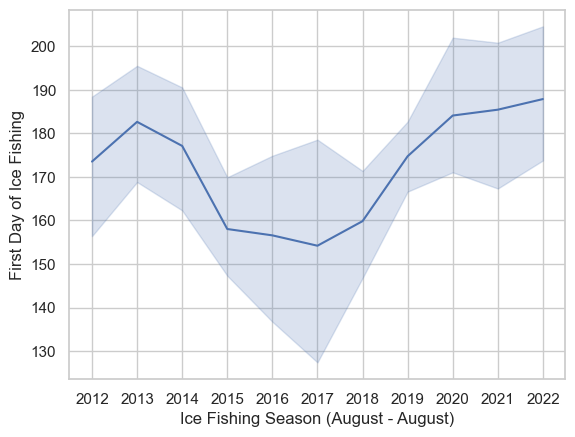

In [99]:
locality_first_catch = pd.read_csv("../data/derived/locality_first_catch.csv")

ax = sns.lineplot(
    data=locality_first_catch.groupby(by=["season", "sellers_locality"])
    .first_catch_day.min()
    .reset_index(),
    x="season",
    y="first_catch_day",
    legend=False,
)
plt.xticks(range(2012, 2023))  # Adjust the range based on your data
ax.set_xlabel("Ice Fishing Season (August - August)")
ax.set_ylabel("First Day of Ice Fishing")

### Local Last Catch


Text(0, 0.5, 'Last Day of Ice Fishing')

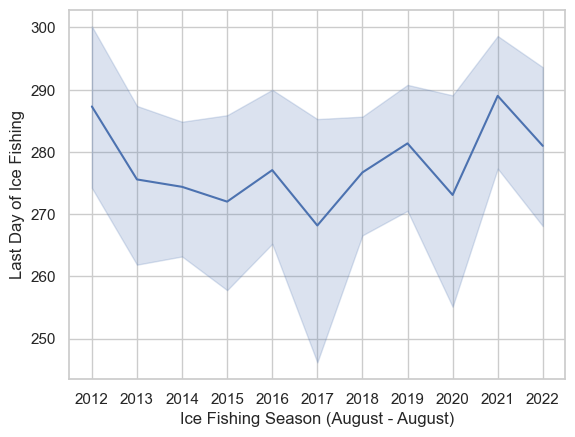

In [100]:
locality_last_catch = pd.read_csv("../data/derived/locality_last_catch.csv")

ax = sns.lineplot(
    data=locality_last_catch.groupby(by=["season", "sellers_locality"])
    .last_catch_day.max()
    .reset_index(),
    x="season",
    y="last_catch_day",
    legend=False,
)
plt.xticks(range(2012, 2023))  # Adjust the range based on your data

ax.set_xlabel("Ice Fishing Season (August - August)")
ax.set_ylabel("Last Day of Ice Fishing")

### Ice Fishing Catch

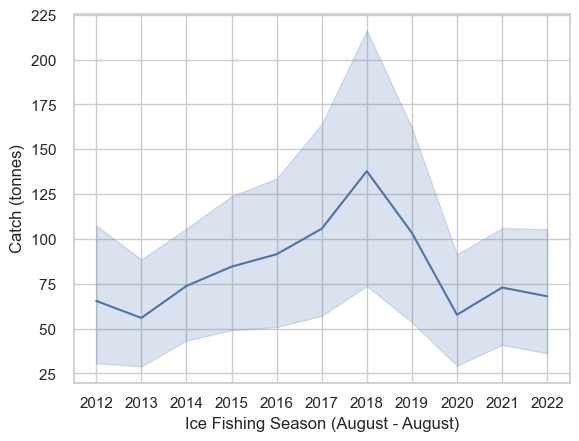

In [144]:
ice_landings = landings.query('vessel_type == "ice"')

ax = sns.lineplot(
    data=ice_landings.groupby(by=["seasonal_year", "sellers_locality"])
    .amount_in_kg.sum()
    .reset_index(),
    x="seasonal_year",
    y="amount_in_kg",
    legend=False,
)
plt.xticks(range(2012, 2023))  # Adjust the range based on your data

ax.set_xlabel("Ice Fishing Season (August - August)")
ax.set_ylabel("Catch (tonnes)")

def millions_formatter(x, pos):
    return f"{x / 1e3:.0f} "

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))


### Number of Fields Fished, 2012-2022


In [101]:
num_fields = pd.read_csv("../data/derived/total_num_fields.csv")
# ax = sns.barplot(data=num_fields, x="season", y="n_fields", color="#b0dac2")


# ax.set_xlabel("Ice Fishing Season (August - August)")
# ax.set_ylabel("Count of Ice Fishing Areas Fished")

### Local Number of Fields fished, 2012-2022

#todo create visualization of this, and stats test


In [102]:
localities = pd.read_csv("../resources/localities.csv")
localities = localities[["locality", "geo_lat"]]

Text(67.24999999999999, 0.5, 'Localities with Ice Fishing Activities, by Descending Latitude (°N)')

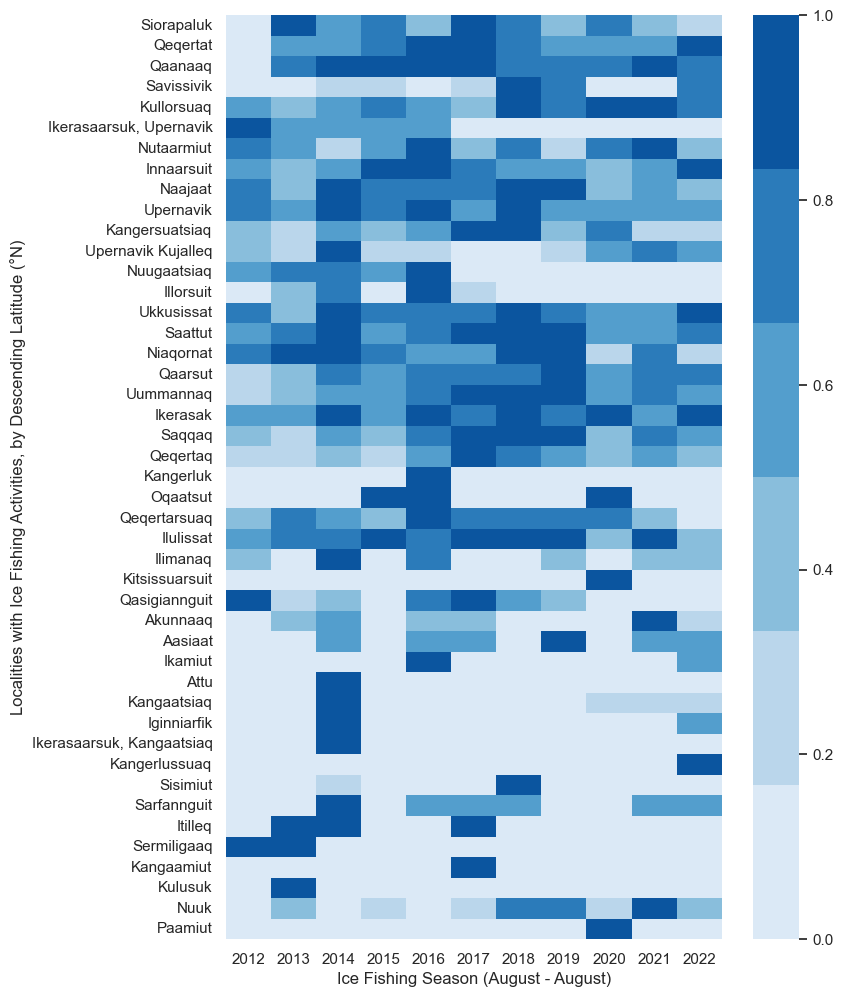

In [103]:
locality_num_fields = pd.read_csv("../data/derived/locality_num_fields.csv")
locality_num_fields = locality_num_fields.pivot(
    index="sellers_locality", columns="seasonal_year", values="n_fields"
).fillna(0)

# Normalize each locality to maximum number of field codes
locality_num_fields = locality_num_fields.div(
    locality_num_fields.max(axis="columns"), axis=0
)

locality_num_fields = (
    locality_num_fields.merge(right=localities, left_index=True, right_on="locality")
    .set_index("locality")
    .sort_values(by="geo_lat", ascending=False)
    .drop(columns="geo_lat")
)
plt.figure(figsize=(8, 12))
custom_cmap = sns.color_palette("Blues")
ax = sns.heatmap(locality_num_fields, cmap=custom_cmap)

ax.set_xlabel("Ice Fishing Season (August - August)")
ax.set_ylabel("Localities with Ice Fishing Activities, by Descending Latitude (°N)")
# plt.text(0.5, -0.09, 'Heat Map of Field Codes Fished, by locality, by year, normalized by each locality to Maximum Number of Field Codes', fontsize=10, ha='center', va='center', transform=plt.gca().transAxes)

## Ice Fishing Season Trend


In [104]:
ice_season_trend = pd.read_csv("../data/derived/ice_season_trend.csv")

# ax = sns.histplot(ice_season_trend, x='ice_season_trend', color= "#b0dac2")

# ax.set_xlabel("Ice Fishing Season Trend (days)")
# ax.set_ylabel("Count")

In [105]:
ice_season_trend

,sellers_locality,ice_season_trend,lat,lon
0,Siorapaluk,-7.169697,77.794783,-70.523647
1,Qeqertat,5.194287,77.494454,-66.671020
2,Qaanaaq,2.753725,77.467142,-69.222302
3,Savissivik,7.783133,76.018281,-65.020361
4,Kullorsuaq,0.701375,74.577534,-57.228747
5,"Ikerasaarsuk, Upernavik",4.000000,73.527222,-56.421893
6,Nutaarmiut,-3.067307,73.516098,-56.430548
7,Innaarsuit,-7.181818,73.198009,-56.014937
8,Naajaat,-0.691156,73.142135,-55.815672
9,Upernavik,-2.091855,72.783478,-56.137418


Text(0, 0.5, 'Latitude (°N)')

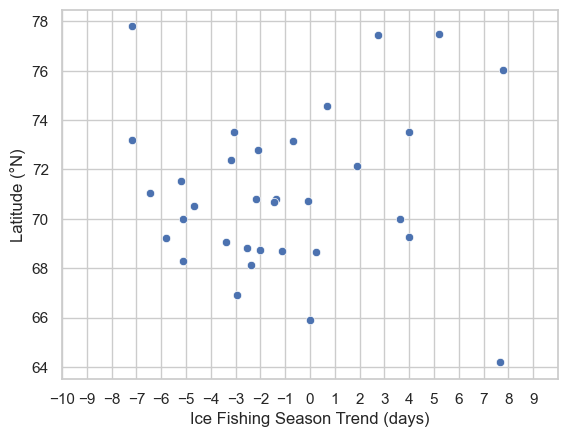

In [106]:
ax = sns.scatterplot(ice_season_trend, x="ice_season_trend", y="lat")

ax.set_xlim([-10, 10])
plt.xticks(range(-10, 10))

ax.set_xlabel("Ice Fishing Season Trend (days)")
ax.set_ylabel("Latitude (°N)")

In [107]:
# ax = sns.lineplot(
#     locality_seasons[locality_seasons.first_or_last == "last"],
#     x="season",
#     y="amount_in_kg",
# )
# plt.xticks(range(2012, 2022))  # Adjust the range based on your data
# ax.set_xlabel("Ice Fishing Season (August - August)")
# ax.set_ylabel("Catch (kg)")

In [150]:
locality_seasons = pd.read_csv("../data/derived/locality_seasons.csv")

locality_seasons['landing_date'] = pd.to_datetime(locality_seasons['landing_date'])

# Filter the dataframe to include only rows where 'first_or_last' is 'last'
filtered_locality_seasons = locality_seasons[locality_seasons['first_or_last'] == 'first']

# Extract month and day components from 'landing_date'
filtered_locality_seasons['landing_month'] = filtered_locality_seasons['landing_date'].dt.month
filtered_locality_seasons['landing_day'] = filtered_locality_seasons['landing_date'].dt.day

# Find the earliest month and day
earliest_month = filtered_locality_seasons['landing_month'].min()
earliest_day = filtered_locality_seasons['landing_day'].min()

print("Earliest Month:", earliest_month)
print("Earliest Day:", earliest_day)

Earliest Month: 1
Earliest Day: 1


/var/folders/4f/0mrpq3dn0tdg8ssxbsgsvt0m0000gn/T/ipykernel_91389/408732349.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_locality_seasons['landing_month'] = filtered_locality_seasons['landing_date'].dt.month
/var/folders/4f/0mrpq3dn0tdg8ssxbsgsvt0m0000gn/T/ipykernel_91389/408732349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_locality_seasons['landing_day'] = filtered_locality_seasons['landing_date'].dt.day
